In [1]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import hist
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import tqdm

import sys
import os
sys.path.append("..")
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from hists.dataframe import DataframeComputations
from utils import makeDashLink, makeCsvRow, printCsvRowsFromDf
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.store import HistogramId

from event_visualizer.notebook_visualizer import EventDisplay
from event_visualizer.event_index import EventLoader

from ratios_utils import makeFrequencyPerBeamEnergy

In [14]:
def filterSpanEnergy(df:pd.DataFrame, comp:DataframeComputations, minLayerSpan=5, minFractionOfBeamEnergy=0.2, maxDistanceTracksterToImpact=1) -> pd.DataFrame:
    """ Filter 3D clusters to keep :
     - min layer span of 3D clusters
     - min fraction of beam energy of 3D clusters (incl synchrotron losses) 
     - max distance trackster to impact (to avoid brehmstrahlung tracksters)
    Then keep only the two highest energy 3D cluster per event (dropping events where only one 3D cluster passes selections)
    Returns dataframe with clus2D_minLayer	clus2D_maxLayer	beamEnergy	clus3D_energy	clus3D_size	clus3D_layerSpan
    Parameter : df : a dataframe holding beamEnergy, clus3D_energy, clus2D_minLayer, clus2D_maxLayer
    """
    return (df
    .eval("clus3D_layerSpan = clus2D_maxLayer - clus2D_minLayer")
    .query("(clus3D_layerSpan >= @minLayerSpan)")
    .join(comp.clusters3D_interpolateImpactAtZ(df, useStaticLayerToZMap=True)) # use static layer map so we don't have to load all rechits
    .query("(clus3D_x - impactX_interpolated)**2 + (clus3D_y - impactY_interpolated)**2 < @maxDistanceTracksterToImpact**2")
    .sort_values(["event","clus3D_energy"])
    .groupby(["eventInternal"]).tail(2) # take the two trackster with max energy in each event
    # Filter events where only one trackster passes selections + filter on beam energy fraction
    .groupby("eventInternal").filter(lambda x : (len(x)>1 and x.clus3D_energy.min() > minFractionOfBeamEnergy*synchrotronBeamEnergiesMap[x.beamEnergy.iloc[0]]))
    .sort_values(["eventInternal", "clus2D_minLayer"])
    )

In [15]:
def unstackDataframe(df:pd.DataFrame):
    """ Unstack the 3D clusters into columns
    Retuyrns a dataframe with multiindex columns, where second layer is 
     - 0 for trackster with smallest first layer
     - 1 for the other trackster
    """
    df_unstacked = (df.assign(clus3D_number=df.groupby("eventInternal").cumcount())
        .reset_index("clus3D_id")
        .set_index("clus3D_number", append=True)
        .unstack()
    )
    #new_df = df_unstacked[["clus3D_id", "clus3D_energy", "clus2D_minLayer", "clus2D_maxLayer", "clus3D_layerSpan"]]
    return df_unstacked

In [16]:
def splitTracksterSelections(df:pd.DataFrame, maxLayerOverlap=2):
    """ Select events where the two tracksters overlap for at most maxLayerOverlap layers """
    return df.loc[df.clus2D_maxLayer[0] - df.clus2D_minLayer[1] < maxLayerOverlap]

In [34]:
def findSplitTracksters(tree, *, minLayerSpan=5, minFractionOfBeamEnergy=0.2, maxLayerOverlap=2, maxDistanceTracksterToImpact=1):
    """ """
    selected_df = []
    total_events = 0
    with tqdm.tqdm(total=tree.num_entries) as pbar:
        for array, report in tree.iterate(step_size="100MB", library="ak", report=True,# entry_stop=10000,
                filter_name=["event", "ntupleNumber", "beamEnergy", "clus3D_energy", "clus3D_size", "clus3D_idxs", "clus2D_layer", 
                            "clus3D_x", "clus3D_y", "clus3D_z", "impactX", "impactY"], 
                ):
            total_events += len(array)
            comp = DataframeComputations(array)
            selected_df.append(comp
                .clusters3D_merged_2D_custom(comp.clusters3D_with_clus2D_id(["ntupleNumber", "event",  "clus3D_x", "clus3D_y", "clus3D_z"]), comp.clusters2D_custom(["clus2D_layer"]))
                .pipe(comp.clusters3D_firstLastLayer, columnsToKeep=["beamEnergy", "ntupleNumber", "event", "clus3D_energy", "clus3D_x", "clus3D_y", "clus3D_z"])

                .pipe(filterSpanEnergy, comp, minLayerSpan=minLayerSpan, minFractionOfBeamEnergy=minFractionOfBeamEnergy, maxDistanceTracksterToImpact=maxDistanceTracksterToImpact)
                .pipe(unstackDataframe)
                .pipe(splitTracksterSelections, maxLayerOverlap=maxLayerOverlap)
            )
            pbar.update(report.stop-report.start)
            
    return pd.concat(selected_df), total_events

def printSplitTracksters(df:pd.DataFrame):
    new_df = df[["beamEnergy", "ntupleNumber", "event"]].loc[:, (slice(None),0)]
    new_df.columns = new_df.columns.droplevel(1) # remove the extra multiindex column level
    printCsvRowsFromDf(new_df, source="SplitTrackster")

In [44]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v40'
clueParams = "cmssw"
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
datatypes = ["data", "sim_proton_v46_patchMIP"]
histStore = HistogramStore(hist_folder, HistogramId)

In [36]:
#histStore = HistogramStore(hist_folder, HistogramId)

#tree = uproot.open('/data_cms_upgrade/cuisset/testbeam18/clue3d/v31/cmssw/data/CLUE_clusters.root:clusters')

In [37]:
def loadDatatype(datatype, settings):
    path = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root:clusters")
    tree = uproot.open(path)
    return findSplitTracksters(tree, **settings)

def loadForSettings(settings):
    return {datatype : loadDatatype(datatype, settings)[0] for datatype in datatypes}
def loadListOfSettings(settings_list):
    return {frozenset(setting.items()) : loadForSettings(setting) for setting in settings_list}

In [40]:
defaultSetting = dict(minLayerSpan=3, minFractionOfBeamEnergy=0.1, maxLayerOverlap=2, maxDistanceTracksterToImpact=1)

In [38]:
# NB : this is slow due to the groupby().apply() call in DataframeComputations.clusters3D_interpolateImpactAtZ
allResults = loadListOfSettings([defaultSetting])

100%|██████████| 359937/359937 [04:33<00:00, 1315.14it/s]


In [41]:
pd.options.display.min_rows = 50
allResults[frozenset(defaultSetting.items())]["data"]

clus3D_id    beamEnergy        ntupleNumber      event         
clus3D_number         0  1          0      1            0    1     0     1   
eventInternal                                                                
3795                  0  1      300.0  300.0          435  435   347   347  \
4054                  0  1       20.0   20.0          436  436   575   575   
4291                  0  1       20.0   20.0          436  436  1986  1986   
4459                  0  1       20.0   20.0          437  437  3024  3024   
4468                  0  1       20.0   20.0          437  437  3092  3092   
4541                  0  1       20.0   20.0          437  437  3572  3572   
4714                  0  1       20.0   20.0          437  437  4589  4589   
4814                  0  1       20.0   20.0          437  437  5241  5241   
5073                  0  1       20.0   20.0          437  437  6790  6790   
5108                  0  2       20.0   20.0          437  437  7039  7039   
5576                  0  2       20.0   20.0          437  437  9772  9772   
5677                  0  1       20.0   20.0          437  437   136   136   
5728                  0  1       20.0   20.0          437  437   478   478   
5942                  0  1       20.0   20.0          437  437  1829  1829   
6031                  0  1       20.0   20.0          437  437  2322  2322   
6221                  0  2       20.0   20.0          439  439  3579  3579   
6285                  0  1       20.0   20.0          439  439  4153  4153   
6299                  0  2       20.0   20.0          439  439  4259  4259   
6308                  0  2       20.0   20.0          439  439  4318  4318   
6377                  0  1       20.0   20.0          439  439  4867  4867   
6379                  0  1       20.0   20.0          439  439  4876  4876   
6405                  0  1       20.0   20.0          439  439  5026  5026   
6594                  0  1       20.0   20.0          439  439  6183  6183   
6624                  0  1       20.0   20.0          439  439  6378  6378   
6667                  0  1       20.0   20.0          439  439  6588  6588   
...                 ... ..        ...    ...          ...  ...   ...   ...   
6578                  0  1      200.0  200.0          665  665   733   733   
6639                  0  1      200.0  200.0          666  666  2655  2655   
6726                  0  1      200.0  200.0          666  666  5537  5537   
7352                  0  1      200.0  200.0          666  666  7023  7023   
7505                  0  1      200.0  200.0          666  666  1911  1911   
7629                  0  1      200.0  200.0          666  666  4980  4980   
8560                  0  1      200.0  200.0          667  667  4951  4951   
8734                  1  2      200.0  200.0          667  667  2122  2122   
8918                  0  1      200.0  200.0          667  667  5667  5667   
9393                  0  1      200.0  200.0          667  667  8548  8548   
9469                  0  1      200.0  200.0          667  667  9130  9130   
10172                 0  1      200.0  200.0          671  671  3187  3187   
10475                 0  1      200.0  200.0          671  671  5602  5602   
10714                 0  2      200.0  200.0          671  671  8314  8314   
11880                 0  1      200.0  200.0          672  672  8008  8008   
12106                 0  1      200.0  200.0          672  672  2901  2901   
12633                 0  1      200.0  200.0          672  672  3155  3155   
13465                 0  1      200.0  200.0          672  672  1033  1033   
13652                 0  1      200.0  200.0          672  672   417   417   
15256                 0  1      200.0  200.0          674  674  2835  2835   
15302                 0  1      200.0  200.0          674  674  5425  5425   
15759                 0  1      200.0  200.0          674  674  6563  6563   
16008                 0  1      200.

In [ ]:
#printSplitTracksters(splitTrackster_df)

In [45]:
def plot(series_dict:dict[str, pd.Series], settings:dict, ax=None, alternative_hypothesis="two-sided"):
    """ 
    Parameters : 
     - series : datatype -> series of beam energies
     - alternative_hypothesis : two-sided or greater 
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    errorbar_kwargs = dict()
    if alternative_hypothesis == "greater":
        errorbar_kwargs["lolims"] = True

    offset_x = 3
    cur_offset = 0
    for datatype, series in series_dict.items():
        ratio_val, ratio_errors = makeFrequencyPerBeamEnergy(histStore, clueParams, series, datatype)
        ax.errorbar(x=np.array(beamEnergies)+cur_offset, y=ratio_val, yerr=ratio_errors, fmt="o-", #ecolor="black", 
                     label=datatypeToLegendMap[datatype], **errorbar_kwargs)
        cur_offset += offset_x

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fraction of split tracksters events")
    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(f"minLayerSpan={settings['minLayerSpan']}, minFracBeamEnergy={settings['minFractionOfBeamEnergy']:.0%}"
                     f"\nmaxLayerOverlap={settings['maxLayerOverlap']}   $e^+$ TB", ax=ax,
        fontsize=15)
    ax.legend()
    #return ratio_val, ratio_errors

def makePlot(settings, datatypes, **kwargs):
    if not isinstance(datatypes, list):
        datatypes = [datatypes]
    plot({datatype : allResults[frozenset(settings.items())][datatype].beamEnergy[0] for datatype in datatypes}, settings, **kwargs)
    

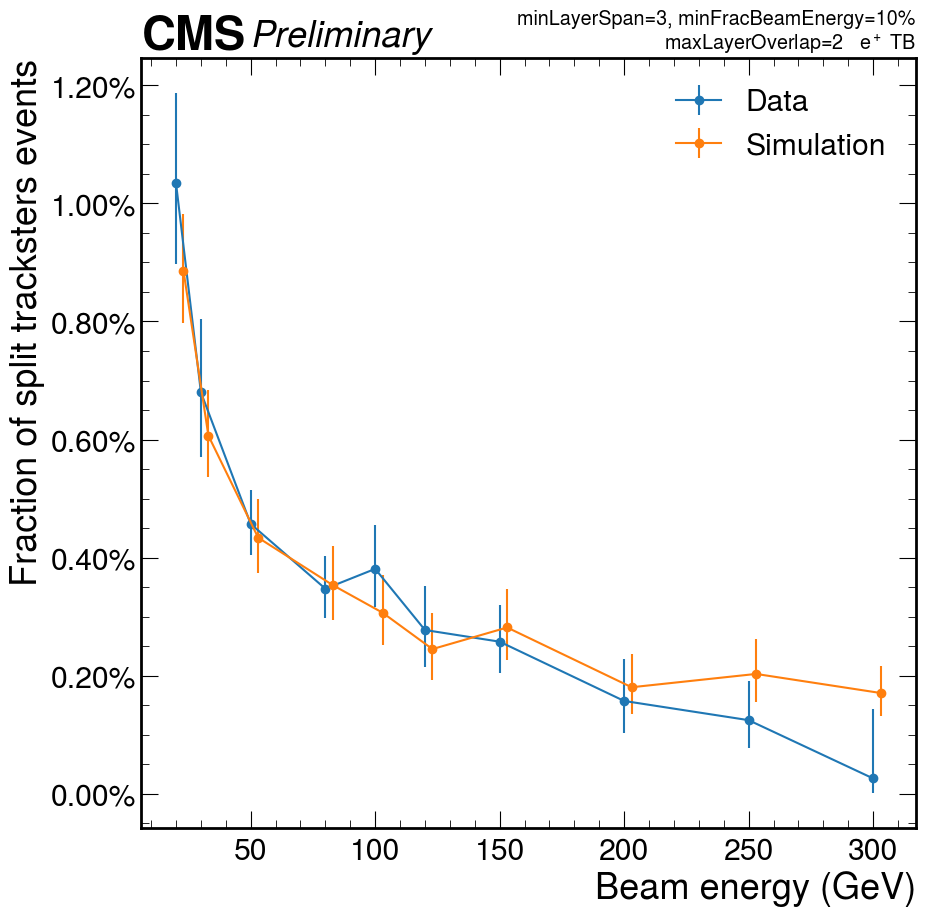

In [63]:
makePlot(defaultSetting, ["data", "sim_proton_v46_patchMIP"], alternative_hypothesis="two-sided")

In [48]:
eventLoader = EventLoader(os.path.join(hist_folder, clueParams, "data", "CLUE_clusters.root"))

In [62]:
results_df = allResults[frozenset(defaultSetting.items())]["data"]
ed = EventDisplay(results_df[[("beamEnergy", 0), ("ntupleNumber", 0), ("event", 0)]].droplevel(level=1, axis="columns"), eventLoader)

Dash is running on http://127.0.0.1:8050/



In [59]:
ed.loadEvent(3795)

(<event_visualizer.event_index.LoadedEvent at 0x7f5a328a69b0>, None)